# Exploration of L3 AIRS Data on O3
-----------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation November 20 ANovembre 2016


### purpose:

Analyse AIRS instrument data from AQUA satellite for LSST air transparency simulation

- http://acdisc.gsfc.nasa.gov/data/Aqua_AIRS_Level3/AIRX3STM.006/

These data are provided by the Goddard Earth Science:

- http://disc.gsfc.nasa.gov/acdisc


In [167]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [169]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [170]:
import pyhdf

In [171]:
from pyhdf.SD import SD,SDC

In [172]:
#dir(SD)

In [173]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 1) Access to the file through pyhdf
-------------------------

### 1.1 Setting the path to the data
--------------------------------

In [174]:
HDFEOS_ZOO_DIR="/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/NASA_AIRS_AQUA_DATA/AIRH3STM/2016/h4"

In [175]:
path=HDFEOS_ZOO_DIR

In [176]:
DATAFIELD_NAME =  'TotO3_D'

In [177]:
DATAFIELD_UNIT = DATAFIELD_NAME+' (Dobson) '

### 1.2 Getting the list of the files
------------------------------

In [178]:
h4_files = [f for f in os.listdir(path) if f.endswith('.hdf')]  
nbfiles=len(h4_files)

for ix in np.arange(0,nbfiles):
    print ix, h4_files[ix]

full_h4file=h4_files
ix=0
for file in h4_files:
    fname = os.path.join(path, file)
    full_h4file[ix]=fname
    ix=ix+1    


0 AIRS.2016.01.01.L3.RetStd031.v6.0.31.0.G16034171018.hdf
1 AIRS.2016.02.01.L3.RetStd029.v6.0.31.0.G16063171358.hdf
2 AIRS.2016.03.01.L3.RetStd031.v6.0.31.0.G16095175654.hdf
3 AIRS.2016.04.01.L3.RetStd030.v6.0.31.0.G16122185324.hdf
4 AIRS.2016.05.01.L3.RetStd031.v6.0.31.0.G16153184258.hdf
5 AIRS.2016.06.01.L3.RetStd030.v6.0.31.0.G16189154115.hdf
6 AIRS.2016.07.01.L3.RetStd031.v6.0.31.0.G16223152110.hdf
7 AIRS.2016.08.01.L3.RetStd031.v6.0.31.0.G16245202845.hdf
8 AIRS.2016.09.01.L3.RetStd030.v6.0.31.0.G16281134124.hdf


### 1.3 Select a given file and open it

In [179]:
fileindex=0 # selecting the file to open : August 2016 

In [180]:
FILE_NAME=full_h4file[fileindex] 

In [181]:
#hdf = SD(FILE_NAME, SDC.READ)

## Build Top directory and figure filename

In [182]:
base_filename=os.path.basename(FILE_NAME).split('.hdf')[0]

In [183]:
print base_filename

AIRS.2016.01.01.L3.RetStd031.v6.0.31.0.G16034171018


In [184]:
p = re.compile('[.]')
root_filename=p.sub('_',base_filename)    
rootimg_dir=os.path.join('test_images',root_filename)

In [185]:
rootimg_dir

'test_images/AIRS_2016_01_01_L3_RetStd031_v6_0_31_0_G16034171018'

In [186]:
ensure_dir(rootimg_dir)

In [187]:
pegfile = "SouthAmerica_{0}_{1}.jpg".format(root_filename, DATAFIELD_NAME)

In [188]:
figfilename=root_filename+'_'+ DATAFIELD_NAME+".pdf"
print figfilename

AIRS_2016_01_01_L3_RetStd031_v6_0_31_0_G16034171018_TotO3_D.pdf


In [189]:
fullfigfilename=os.path.join(rootimg_dir,figfilename)

In [190]:
fullpegfile=os.path.join(rootimg_dir,pegfile)

## Functions

In [191]:
def GetData(file,datafield):
    hdf = SD(file, SDC.READ)
    data3D=hdf.select(datafield)
    return data3D

### 1.4 retrieve the 3D Data

In [192]:
data3D =GetData(FILE_NAME,DATAFIELD_NAME)
data= data3D[:,:] ## Ozone has no additional dimensions

### 1.5 Read GeoLocation

In [193]:
# Read geolocation dataset.
lat = GetData(FILE_NAME,'Latitude')
latitude = lat[:,:]
lon = GetData(FILE_NAME,'Longitude')
longitude = lon[:,:]


In [194]:
# Handle fill value.
attrs = data3D.attributes(full=1)
fillvalue=attrs["_FillValue"]

# fillvalue[0] is the attribute value.
fv = fillvalue[0]
data[data == fv] = np.nan
data = np.ma.masked_array(data, np.isnan(data))

In [195]:
pp = PdfPages(fullfigfilename)

### 1.4 Data analysis
----------------------

#### 1.4.1 list of quantities to analyse

### Location of the CTIO site
------------------------------------
- Longitude = -70.815 deg
- Latitude  = -30.165277777777778 deg
- Quantity  = 2214.9999999993697 m

In [196]:
#CTIO site
Longitude_ctio = -70.815  # deg
Latitude_ctio = -30.165277777777778 #deg
Altitude_ctio = 2214.9999999993697 #m

## 2 Analysis of H2O
--------------------------------------

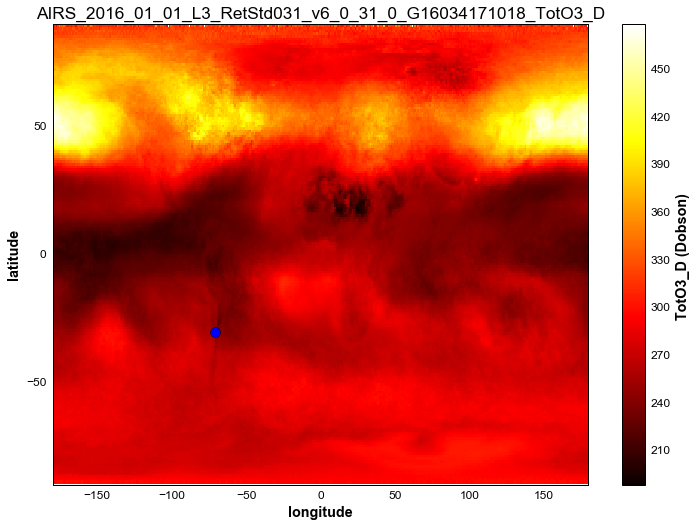

In [197]:
fig=plt.figure(figsize=(12,8))
im = plt.pcolormesh(longitude,latitude,data, cmap='hot')
cbar=plt.colorbar(im, orientation='vertical')
cbar.set_label(DATAFIELD_UNIT)
plt.axis([-180., 180., -90, 90 ])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.plot([Longitude_ctio],[Latitude_ctio],'bo',markersize=10)
title=root_filename+'_'+ DATAFIELD_NAME
plt.title(title)
#plt.tight_layout()
plt.savefig(pp, format='pdf')
plt.show()

##### Using basemap

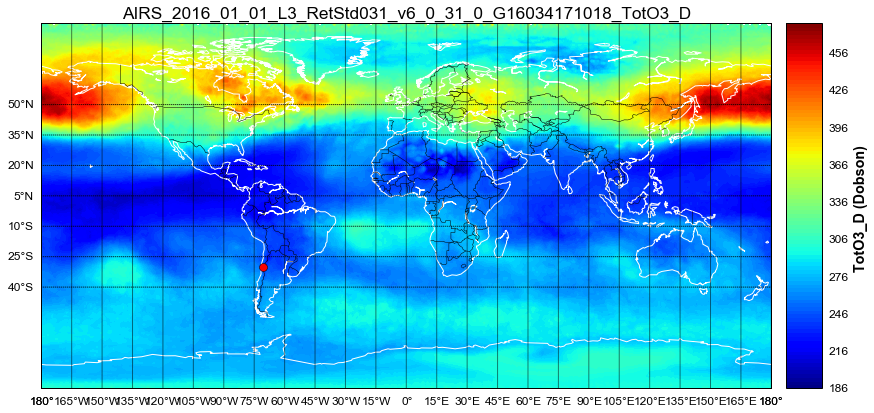

In [198]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(14,14))
map = Basemap()
map.drawcoastlines(color="white")
map.drawcountries(color="black")
img=map.contourf(longitude,latitude, data,100)
cbar=map.colorbar(img,"right", size="5%", pad="2%")
cbar.set_label(DATAFIELD_UNIT)
map.drawparallels(np.arange(-40,61.,15.),labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,180.,15.),labels=[True,False,False,True])
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
map.plot(xpt_ctio,ypt_ctio,marker='o',color='r',markersize=8)  # plot a red dot there
title=root_filename+'_'+ DATAFIELD_NAME
plt.title(title)
#plt.tight_layout() 
plt.savefig(pp, format='pdf')
plt.show()

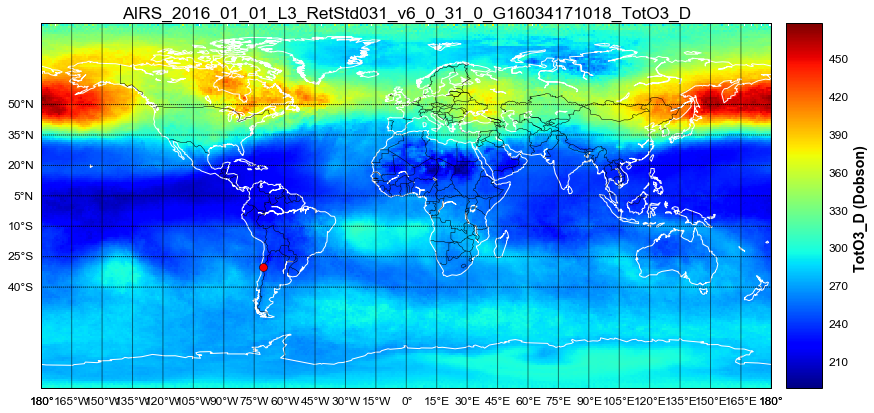

In [199]:

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(14,14))
map = Basemap()
map.drawcoastlines(color="white")
map.drawcountries(color="black")
#img=map.contourf(X, Y, aod_clean,100)
img = plt.pcolormesh(longitude,latitude,data)
cbar=map.colorbar(img,"right", size="5%", pad="2%")
cbar.set_label(DATAFIELD_UNIT)
map.drawparallels(np.arange(-40,61.,15.),labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,180.,15.),labels=[True,False,False,True])
xpt_ohp,ypt_ohp = map(Longitude_ctio,Latitude_ctio)
map.plot(xpt_ctio,ypt_ctio,'ro',markersize=8)  # plot a red dot there
title=root_filename+'_'+ DATAFIELD_NAME
plt.title(title)
#plt.tight_layout() 
plt.savefig(pp, format='pdf')
plt.show()

#### South America
-----------------

In [200]:
#LSST site
Longitude_lsst = -70.7366833333333 # deg
Latitude_lsst = -30.240741666666672 #deg
Altitude_lsst = 2749.999999999238 #m
#CTIO Site
Longitude_ctio = -70.815 # deg
Latitude_ctio = -30.165277777777778 #deg
Altitude_ctio = 2214.9999999993697 #m
# Cerro Paranal
Longitude_paranal = -70.40300000000002 #deg
Latitude_paranal  = -24.625199999999996 #deg
Altitude_paranal = 2635.0000000009704 #m
# Observatoire de Haute Provence
Longitude_ohp=5.71222222222
Latitude_ohp=43.9316666667
Altitude_ohp=650.

#### define south america

- longitude -100° to -30°
- latitude -55° to 15°

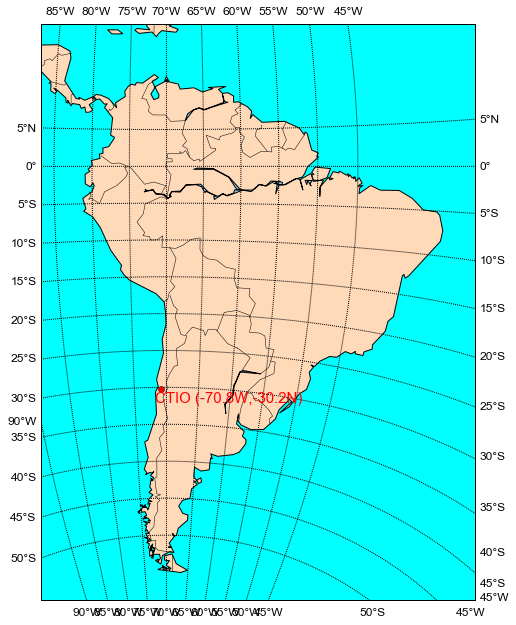

In [201]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
map = Basemap(llcrnrlon=-100,llcrnrlat=-55,urcrnrlon=-30.,urcrnrlat=15., projection='tmerc', lat_0 = -30, lon_0 = -70)
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='peachpuff',lake_color='lightskyblue')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(-50,10,5.),labels=[True,True,True,True])
map.drawmeridians(np.arange(-90.,-40.,5.),labels=[True,True,True,True])

xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
# convert back to lat/lon
#lonpt, latpt = map(xpt_lsst,ypt_lsst,inverse=True)
map.plot(xpt_ctio,ypt_ctio,'ro')  # plot a red dot there
# put some text next to the dot, offset a little bit
# (the offset is in map projection coordinates)
plt.text(xpt_ctio-100000,ypt_ctio-200000,'CTIO (%5.1fW,%3.1fN)' % (Longitude_ctio,Latitude_ctio),color='red', fontsize=15)
#plt.tight_layout()
#plt.savefig(pp, format='pdf')
plt.show()


### Region and Data selection for South America

In [202]:
LongMin=-100
LongMax=-30
LatMin=-55
LatMax=15

In [203]:
X=longitude
Y=latitude

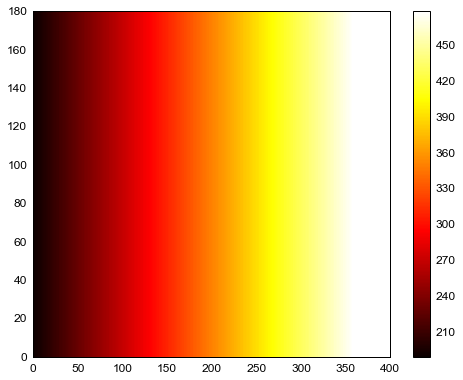

In [204]:
plt.pcolormesh(X, cmap='hot')
plt.colorbar(im, orientation='vertical')

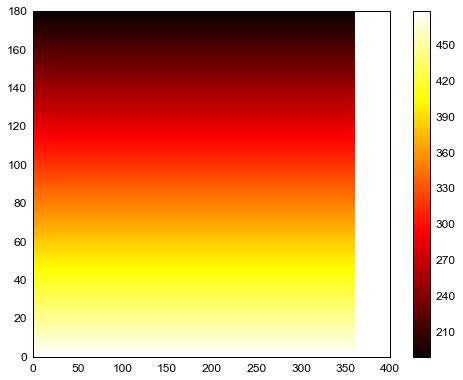

In [205]:
plt.pcolormesh(Y, cmap='hot')
plt.colorbar(im, orientation='vertical')

In [206]:
def AreaSelect(X,Y,data,LongMin,LongMax,LatMin,LatMax):
    flags_long=np.logical_and(X>=LongMin, X<=LongMax)   # flags in X where are the selected longitudes
    flags_lat=np.logical_and(Y>=LatMin, Y<=LatMax)      # flags in Y where are the selected longitudes
    flags_longlat=np.logical_and(flags_long,flags_lat)  # flags where the region is selected in the long-lat matrix

    (selected_lat_indexes,selected_long_indexes)=np.where(flags_longlat==True) # list of indexes
    selected_long=longitude[:,selected_long_indexes] # all selected longitudes
    selected_lat=latitude[selected_lat_indexes,:]    # all selected latitudes

    min_long_index=np.min(selected_long_indexes)
    max_long_index=np.max(selected_long_indexes)

    min_lat_index=np.min(selected_lat_indexes)
    max_lat_index=np.max(selected_lat_indexes)

    # output    
    extracted_data=data[min_lat_index:max_lat_index,min_long_index:max_long_index] # extract the data
    Xsel=X[min_lat_index:max_lat_index,min_long_index:max_long_index] # extract the Long
    Ysel=Y[min_lat_index:max_lat_index,min_long_index:max_long_index] # extract the lat
    
    return Xsel,Ysel,extracted_data

In [207]:
(Xsel,Ysel,extracted_data) = AreaSelect(X,Y,data,LongMin,LongMax,LatMin,LatMax)

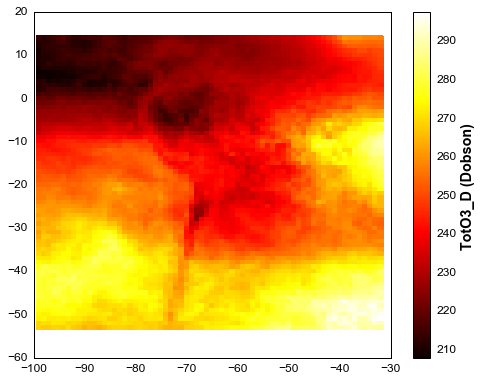

In [208]:
im=plt.pcolormesh(Xsel,Ysel,extracted_data, cmap='hot')
cbar=plt.colorbar(im, orientation='vertical')
cbar.set_label(DATAFIELD_UNIT)

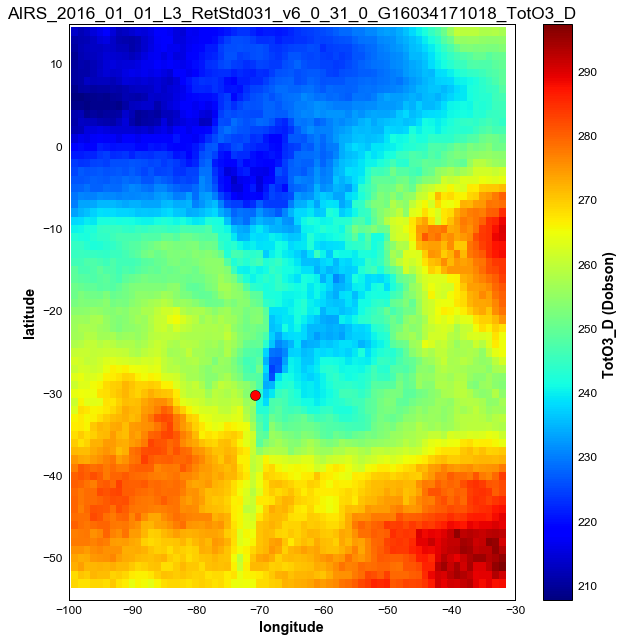

In [209]:
plt.figure(figsize=(10,10))
#newdata=np.where(flags_longlat,data  , 0 )  # clean the aod from creazy data
#image = plt.pcolormesh(X,Y,newdata, cmap='hot')
image = plt.pcolormesh(Xsel,Ysel,extracted_data)
plt.xlim(LongMin,LongMax)
plt.ylim(LatMin,LatMax)
plt.plot([Longitude_ctio],[Latitude_ctio],'ro',markersize=10)
plt.xlabel('longitude')
plt.ylabel('latitude')
title=root_filename+'_'+ DATAFIELD_NAME
plt.title(title)
#plt.tight_layout()
cbar=plt.colorbar(image, orientation='vertical')
cbar.set_label(DATAFIELD_UNIT)
plt.savefig(pp, format='pdf')
plt.show()

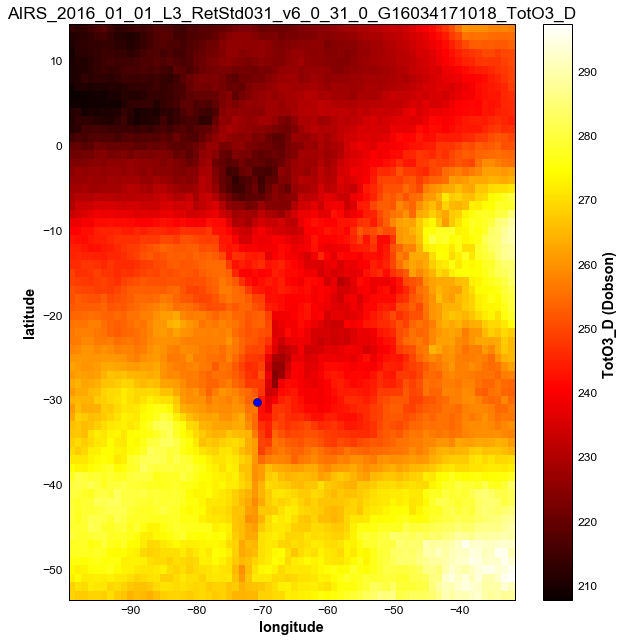

In [210]:
plt.figure(figsize=(10,10))
#Xsel,Ysel=np.meshgrid(selected_long,selected_lat)
im = plt.pcolormesh(Xsel,Ysel,extracted_data, cmap='hot')
cbar=plt.colorbar(im, orientation='vertical')
cbar.set_label(DATAFIELD_UNIT)
plt.axis([Xsel.min(), Xsel.max(), Ysel.min(), Ysel.max()])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.plot([Longitude_ctio],[Latitude_ctio],marker='o',color='b',markersize=8)
#title="Aerosol Optical Depth AOD above europe"
title=root_filename+'_'+ DATAFIELD_NAME
plt.title(title)
#plt.tight_layout()
plt.savefig(pp, format='pdf')
plt.show()

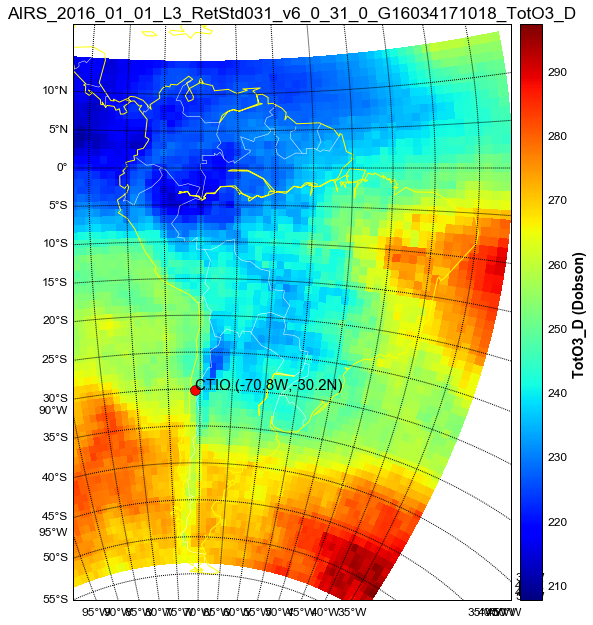

In [211]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
map = Basemap(llcrnrlon=LongMin,llcrnrlat=LatMin,urcrnrlon=LongMax,urcrnrlat=LatMax, projection='tmerc', lat_0 = Latitude_ctio, lon_0 = Longitude_ctio)
#map.drawmapboundary(fill_color='aqua') # No fill color
#map.fillcontinents(color='peachpuff',lake_color='lightskyblue') # No fill color
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
# convert back to lat/lon
#lonpt, latpt = map(xpt_lsst,ypt_lsst,inverse=True)
map.plot(xpt_ctio,ypt_ctio,'ro')  # plot a red dot there
img=map.pcolormesh(Xsel,Ysel,extracted_data,shading='flat',latlon=True)
#img=map.contourf(Xsel, Ysel, extracted_aod,100)
cbar=map.colorbar(img,"right", size="5%", pad="2%")
cbar.set_label(DATAFIELD_UNIT)
map.drawparallels(np.arange(LatMin,LatMax,5.),labels=[True,False,False,False])
map.drawmeridians(np.arange(LongMin,LongMax,5.),labels=[True,True,False,True])
map.drawcoastlines(color='yellow')
map.drawcountries(color='white')
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
map.plot(xpt_ctio,ypt_ctio,'ro',markersize=10)  # plot a red dot there
plt.text(xpt_ctio-1000,ypt_ctio-1000,'CTIO (%5.1fW,%3.1fN)' % (Longitude_ctio,Latitude_ctio),color='black', fontsize=15)
title=root_filename+'_'+ DATAFIELD_NAME
plt.title(title)
#plt.tight_layout()
plt.savefig(fullpegfile)
plt.savefig(pp, format='pdf')
plt.show()

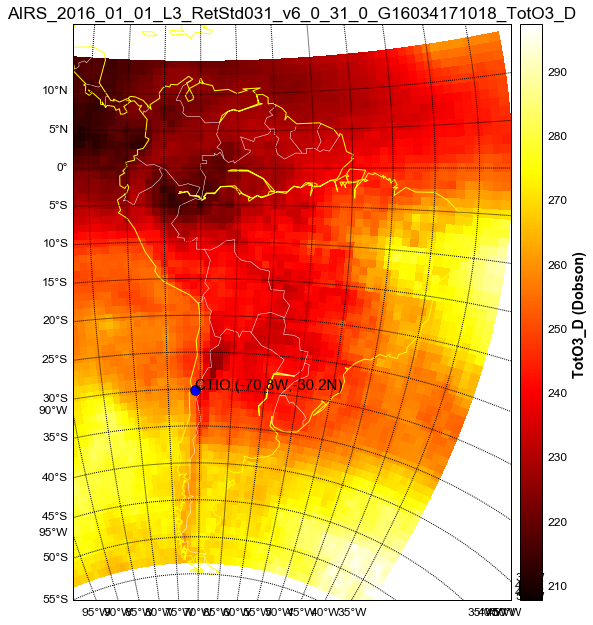

In [212]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
map = Basemap(llcrnrlon=LongMin,llcrnrlat=LatMin,urcrnrlon=LongMax,urcrnrlat=LatMax, projection='tmerc', lat_0 = Latitude_ctio, lon_0 = Longitude_ctio)
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
# convert back to lat/lon
#lonpt, latpt = map(xpt_lsst,ypt_lsst,inverse=True)
map.plot(xpt_ctio,ypt_ctio,'ro')  # plot a red dot there
img=map.pcolormesh(Xsel,Ysel,extracted_data,shading='flat',cmap="hot",latlon=True)
#img=map.contourf(Xsel, Ysel, extracted_aod,20)
cbar=map.colorbar(img,"right", size="5%", pad="2%")
cbar.set_label(DATAFIELD_UNIT)
map.drawparallels(np.arange(LatMin,LatMax,5.),labels=[True,False,False,False])
map.drawmeridians(np.arange(LongMin,LongMax,5.),labels=[True,True,False,True])
map.drawcoastlines(color='yellow')
map.drawcountries(color='white')
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
map.plot(xpt_ctio,ypt_ctio,'bo',markersize=10)  # plot a red dot there
plt.text(xpt_ctio-1000,ypt_ctio-1000,'CTIO (%5.1fW,%3.1fN)' % (Longitude_ctio,Latitude_ctio),color='black', fontsize=15)
title=root_filename+'_'+ DATAFIELD_NAME
plt.title(title)
#plt.tight_layout()
plt.savefig(pp, format='pdf')
plt.show()

#### Find O3 data for CTIO site
------------------------------

In [213]:
def SelectBin(X,Y,data,Long0,Lat0,DLong=1.0,DLat=1.0):
    sel_flags_long=np.logical_and(X>=Long0-float(DLong)/2., X<=Long0+float(DLong)/2.)   # flags in X where are the selected longitudes
    sel_flags_lat=np.logical_and(Y>=Lat0-float(DLat)/2., Y<=Lat0+float(DLat)/2.)      # flags in Y where are the selected longitudes
    sel_flags_longlat=np.logical_and(sel_flags_long,sel_flags_lat)  # flags where the region is selected in the long-lat matrix

    (selected_lat_indexes,selected_long_indexes)=np.where(sel_flags_longlat==True) # list of indexes


    selected_X=X[:,selected_long_indexes] # all selected longitudes
    selected_Y=Y[selected_lat_indexes,:] 

    sel_min_long_index=np.min(selected_long_indexes)
    sel_max_long_index=np.max(selected_long_indexes)

    sel_min_lat_index=np.min(selected_lat_indexes)
    sel_max_lat_index=np.max(selected_lat_indexes)

    extracted_data=data[sel_min_lat_index:sel_max_lat_index+1,sel_min_long_index:sel_max_long_index+1] # extract the data
    
    return sel_min_long_index,sel_min_lat_index,extracted_data[0][0]

In [214]:
(ctio_min_long_index, ctio_min_lat_index,extrdata)=SelectBin(X,Y,data,Longitude_ctio,Latitude_ctio)

In [215]:
print('ctio_min_lat_index=',ctio_min_lat_index)
print('ctio_min_long_index=',ctio_min_long_index)
print('ctio_data = ',extrdata,DATAFIELD_UNIT)

('ctio_min_lat_index=', 120)
('ctio_min_long_index=', 109)
('ctio_data = ', 242.42188, 'TotO3_D (Dobson) ')


### Find size of AIRS box at CTIO location

In [216]:
#distance along longitude
x1,y1 = map(Longitude_ctio-0.5,Latitude_ctio)
x2,y2 = map(Longitude_ctio+0.5,Latitude_ctio)
d_long=np.sqrt((x2-x1)**2+(y2-y1)**2)/1000

In [217]:
print x1,x2,y1,y2
print d_long,' km'

1788748.74085 1885075.34489 3156138.72334 3156138.72334
96.3266040492  km


In [218]:
#distance along latitude
x1,y1 = map(Longitude_ctio,Latitude_ctio-0.5)
x2,y2 = map(Longitude_ctio,Latitude_ctio+0.5)
d_lat=np.sqrt((x2-x1)**2+(y2-y1)**2)/1000

In [219]:
print x1,x2,y1,y2
print d_lat,' km'

1836912.04287 1836912.04287 3100814.58853 3211669.83536
110.855246827  km


## Close the pdf file
-------------------------

In [220]:
pp.close()